# Notebook

## Setting up

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import warnings
import time

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from datasets import Dataset
from datasets import DatasetDict
from datasets import load_metric

from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import TextClassificationPipeline
from transformers import pipeline

# suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [56]:
df = pd.read_pickle("data/data_original.pkl")

down_sample_percentage = 0.5

# down sample data
df = df.sample(frac=down_sample_percentage/100, random_state=1)

# rename emotions to label and map to integers
df.rename(columns={'emotions':'label'}, inplace = True)
label_map = {"sadness": 0, "joy": 1, "love": 2, "anger": 3, "fear": 4, "surprise": 5} 
df['label'] = df['label'].map(label_map)

print(df.shape)
df.head()

(2084, 2)


,text,label
98790,i wanted them to feel now i feel as though i a...,0
18398,i found myself feeling very sympathetic toward...,2
139349,ive been feeling pretty good today and tonight...,1
13416,i can use to cover my ass when i feel inadequate,0
22297,i feel like ive pissed myself again,3


In [57]:
dataset = Dataset.from_pandas(df)

# 80% train, 20% test+validation
train_test = dataset.train_test_split(test_size=0.2)

# Split the 10% test+validation set in half test, half validation
valid_test = train_test['test'].train_test_split(test_size=0.5)

# gather everyone if you want to have a single DatasetDict
train_valid_test_dataset = DatasetDict({
    'train': train_test['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

print(train_valid_test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1667
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 208
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 209
    })
})


## Fine-tuning a pre-trained Hugging Face model

We need to load:
- the pre-trained model itself
- the tokenizer associated with the model (used to preprocess the data)

In [58]:
model_name = "distilbert-base-uncased" # bert-base-uncased

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Pre-processing the data with the tokenizer

In [59]:
def preprocess_function(sample):
    return tokenizer(sample["text"], padding=True, truncation=True, return_tensors="pt")

tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

print(tokenized_dataset)

Map:   0%|          | 0/1667 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Map:   0%|          | 0/209 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1667
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 208
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 209
    })
})


The preprocessing transforms the data into a format that the model can understand. The model then processes the data to make predictions. This is known as **encoding**. Encoding is done in a two-step process: tokenization, followed by conversion to input IDs.

In [60]:
# print(tokenized_dataset['train'][321])
# tokens = tokenizer.tokenize(tokenized_dataset['train'][321]['text'])
# print(tokens)
# ids = tokenizer.convert_tokens_to_ids(tokens)
# print(ids)

### Model training (Fine-tuning)

In [61]:
def predict(text):
    global model, tokenizer
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
    print(predictions)
    predicted_class = torch.argmax(predictions)
    name = [i for i, j in label_map.items() if j == predicted_class.item()][0]
    print(f"Predicted class: {name}")
    
# predict("I'm so sad")

In [62]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [63]:
trainer.evaluate()

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.7908439636230469,
 'eval_accuracy': 0.11538461538461539,
 'eval_runtime': 4.7809,
 'eval_samples_per_second': 43.506,
 'eval_steps_per_second': 2.719}

In [64]:
start = time.time()
trainer.train()
end = time.time()
print(f"Training time: {(end - start)/60} minutes")

  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.2052730321884155, 'eval_accuracy': 0.5673076923076923, 'eval_runtime': 8.182, 'eval_samples_per_second': 25.422, 'eval_steps_per_second': 1.589, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.8755763173103333, 'eval_accuracy': 0.7163461538461539, 'eval_runtime': 6.8395, 'eval_samples_per_second': 30.412, 'eval_steps_per_second': 1.901, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7949233651161194, 'eval_accuracy': 0.7307692307692307, 'eval_runtime': 6.8694, 'eval_samples_per_second': 30.279, 'eval_steps_per_second': 1.892, 'epoch': 3.0}
{'train_runtime': 680.2158, 'train_samples_per_second': 7.352, 'train_steps_per_second': 0.463, 'train_loss': 1.0385885571676587, 'epoch': 3.0}
Training time: 11.34089127779007 minutes


In [65]:
trainer.evaluate()

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7949233651161194,
 'eval_accuracy': 0.7307692307692307,
 'eval_runtime': 6.5758,
 'eval_samples_per_second': 31.631,
 'eval_steps_per_second': 1.977,
 'epoch': 3.0}

In [66]:
trainer.predict(test_dataset=tokenized_dataset["test"])

  0%|          | 0/14 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[ 0.35560498, -0.78767693, -0.5049101 ,  2.0521035 , -0.23063692,
        -1.0384375 ],
       [-1.1847161 ,  2.468626  ,  0.80642134, -1.0553157 , -0.944239  ,
        -0.64423555],
       [ 2.8648057 , -0.99488986, -0.93769944, -0.5550857 , -0.17947657,
        -0.78057027],
       ...,
       [-1.1639847 ,  2.1524012 ,  0.879532  , -1.023411  , -0.91544455,
        -0.73866177],
       [-1.0319915 ,  1.8236094 ,  0.86332786, -1.0626013 , -0.85290533,
        -0.5556187 ],
       [ 2.4935002 , -0.52386636, -0.7561412 , -0.79141366, -0.24419573,
        -0.99072266]], dtype=float32), label_ids=array([3, 1, 0, 1, 0, 1, 5, 0, 2, 2, 0, 0, 1, 5, 2, 4, 4, 0, 4, 4, 3, 1,
       4, 1, 2, 0, 0, 1, 0, 5, 1, 4, 1, 0, 0, 4, 4, 0, 1, 3, 1, 1, 1, 1,
       3, 0, 0, 1, 5, 2, 3, 3, 4, 0, 2, 1, 2, 0, 3, 0, 3, 3, 5, 3, 3, 1,
       2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 2, 4, 0, 2, 3,
       2, 1, 4, 1, 0, 1, 3, 0, 1, 1, 1, 2, 3, 1, 1, 1, 0, 4, 1, 3, 3, 

### Save & Load Model

In [67]:
trainer.save_model()

tokenizer2 = AutoTokenizer.from_pretrained("./results")
model2 = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=6)

pipe = TextClassificationPipeline(model=model2, tokenizer=tokenizer2) #, return_all_scores=True)

# pipe("I love this place!")
# pipe("Paris was very disappointing")

### Evaluate Model Results

In [68]:
def show_cm(cm, classes, figsize=(10, 10)):
    # cm = np.array([[TP, FP], [FN, TN]])
    plt.figure(figsize=figsize)
    plt.imshow(cm)
    plt.suptitle('Confusion matrix')
    total = sum(sum(cm))
    plt.title('Total cases: {}'.format(total))
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            perc = round(cm[i, j] / total * 100, 1)
            plt.text(j, i, f"{format(cm[i, j], '.0f')} : {perc}%", horizontalalignment="center",
                     color="black" if cm[i, j] > cm.max() / 2 else "white")

    plt.show()

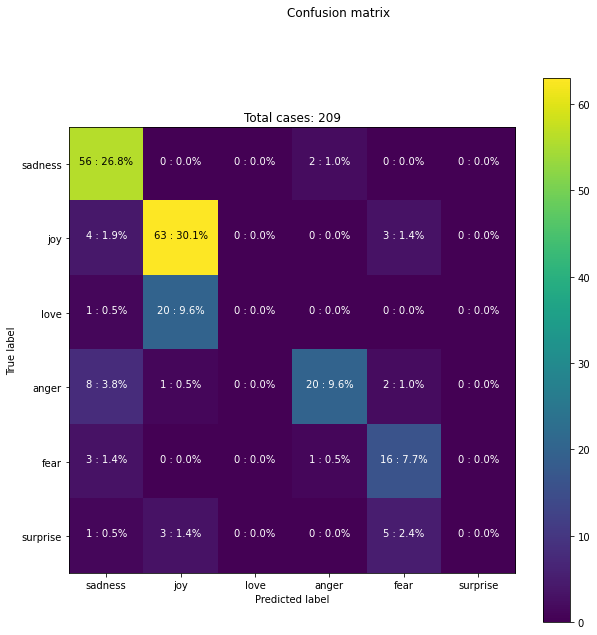

Accuracy:  0.7416267942583732
Precision:  0.4960351752469392
Recall:  0.5517797552836484
F1:  0.5156504195692483


/home/m/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [69]:
y_pred= []
for p in tokenized_dataset['test']['text']:
    ti = tokenizer2(p, return_tensors="pt")
    out = model2(**ti)
    pred = torch.argmax(out.logits)
    y_pred.append(pred)
    
y_test = tokenized_dataset['test']['label']

show_cm(confusion_matrix(y_test, y_pred), label_map.keys())
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print('F1: ', f1_score(y_test, y_pred, average='macro'))